### Node2vec

In [1]:
import os
#os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages graphframes:graphframes:0.6.0-spark2.3-s_2.11 pyspark-shell'
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages graphframes:graphframes:0.7.0-spark2.3-s_2.11 pyspark-shell'
#os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages graphframes:graphframes:0.8.0-spark3.0-s_2.12 pyspark-shell'

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import udf
import matplotlib.pyplot as plt

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import HiveContext
from pyspark.sql import SQLContext
import pyspark.sql.functions as sf
from pyspark.sql.types import *
from pyspark.storagelevel import StorageLevel

In [3]:
sc = pyspark.SparkContext("local[*]")
spark = SparkSession.builder.appName('notebook').getOrCreate()

In [4]:
spark

In [5]:
import sys
import os
import pyspark
from pyspark.sql import *
from graphframes import *
from functools import reduce
import hashlib
import pandas as pnd

### Load Data

In [6]:
dataset_f = 'data/FullData_fifa_2017.csv'
data = pnd.read_csv(dataset_f , 
        usecols=['Name', 'Club', 'Club_Position', 'Rating','Nationality'])

In [7]:
data.head()

,Name,Nationality,Club,Club_Position,Rating
0,Cristiano Ronaldo,Portugal,Real Madrid,LW,94
1,Lionel Messi,Argentina,FC Barcelona,RW,93
2,Neymar,Brazil,FC Barcelona,LW,92
3,Luis Suárez,Uruguay,FC Barcelona,ST,92
4,Manuel Neuer,Germany,FC Bayern,GK,92


In [8]:
# Lowercase columns for convenience
data.columns = list(map(str.lower, data.columns))

# Lowercase position
data['club_position'] = data['club_position'].str.lower()

# Ignore substitutes and reserves 
data = data[(data['club_position'] != 'sub') & (data['club_position'] != 'res')]

In [9]:
# Fix lcm rcm -> cm cm
fix_positions = {'rcm' : 'cm', 'lcm': 'cm', 'rcb': 'cb', 'lcb': 'cb', 'ldm': 'cdm', 'rdm': 'cdm'}
data['club_position'] = data['club_position'].apply(lambda x: fix_positions.get(x, x))

In [10]:
data = data.applymap(str)

In [11]:
df_sample_data = spark.createDataFrame(data)

In [12]:
df_sample_data.show()

+------------------+-----------+---------------+-------------+------+
|              name|nationality|           club|club_position|rating|
+------------------+-----------+---------------+-------------+------+
| Cristiano Ronaldo|   Portugal|    Real Madrid|           lw|    94|
|      Lionel Messi|  Argentina|   FC Barcelona|           rw|    93|
|            Neymar|     Brazil|   FC Barcelona|           lw|    92|
|       Luis Suárez|    Uruguay|   FC Barcelona|           st|    92|
|      Manuel Neuer|    Germany|      FC Bayern|           gk|    92|
|            De Gea|      Spain| Manchester Utd|           gk|    90|
|Robert Lewandowski|     Poland|      FC Bayern|           st|    90|
|       Gareth Bale|      Wales|    Real Madrid|           rw|    90|
|Zlatan Ibrahimović|     Sweden| Manchester Utd|           st|    90|
|  Thibaut Courtois|    Belgium|        Chelsea|           gk|    89|
|       Eden Hazard|    Belgium|        Chelsea|           lw|    89|
|       Luka Modrić|

In [13]:
#erase
sys.path.insert(0, '../gremlibXL')
#----- gremlibXL ----
from graph_preproc import *

In [14]:
edge_descriptions = [EdgeDescriptor(src='name',dst='club',directed=False),
                     EdgeDescriptor(src='name',dst='club_position',directed=False),
                    ]

In [15]:
edge_descriptions

In [16]:
tab2grab_transformer = Tab2graph(edge_descriptions=edge_descriptions, N_PART_G=6, USE_WEIGHTS=True)

In [17]:
tab2grab_transformer

### PARTITIONS OF THE DATA

In [18]:
sys.path.insert(0, '../')
from part_tab_data import *

In [19]:
ls_part_tab = partitions_from_field_values(i_df = df_sample_data,
                                           field_name = 'nationality')

ls_part_tab = [el.rdd.toDF(el.schema).persist() for el in ls_part_tab]

In [20]:
ls_part_tab[0].describe().show()

+-------+----------------+-----------+---------+-------------+-----------------+
|summary|            name|nationality|     club|club_position|           rating|
+-------+----------------+-----------+---------+-------------+-----------------+
|  count|             109|        109|      109|          109|              109|
|   mean|            null|       null|     null|         null|69.69724770642202|
| stddev|            null|       null|     null|         null|6.010029560468318|
|    min|Adessoye Oyewole|     Russia|Aarhus GF|          cam|               55|
|    max|   Yuriy Lodygin|     Russia|    Zenit|           st|               81|
+-------+----------------+-----------+---------+-------------+-----------------+



In [21]:
ls_part_tab[1].describe().show()

+-------+------------+-----------+---------+-------------+-----------------+
|summary|        name|nationality|     club|club_position|           rating|
+-------+------------+-----------+---------+-------------+-----------------+
|  count|          34|         34|       34|           34|               34|
|   mean|        null|       null|     null|         null|             71.5|
| stddev|        null|       null|     null|         null|3.871026799810156|
|    min|Bruno Valdez|   Paraguay| Al Nassr|          cam|               63|
|    max|Victor Ayala|   Paraguay|Wanderers|           st|               78|
+-------+------------+-----------+---------+-------------+-----------------+



In [22]:
l_sg = graphs_from_list(list_subg_records = ls_part_tab,tab2grab_transformer = tab2grab_transformer)

In [23]:
l_sg[20].edges.show(10,False)

+----------------------+------------------+------+
|src                   |dst               |weight|
+----------------------+------------------+------+
|Nabil Ghilas          |Gaziantepspor     |1     |
|Riyad Mahrez          |Leicester City    |1     |
|Djamel Eddine Benlamri|Al Shabab         |1     |
|Florian Makhedjouf    |Red Star FC       |1     |
|Mehdi Mostefa         |SC Bastia         |1     |
|Féthi Harek           |Nîmes Olympique   |1     |
|Karim Ziani           |US Orléans        |1     |
|Red Star FC           |Florian Makhedjouf|1     |
|SC Bastia             |Mehdi Mostefa     |1     |
|Real Betis            |Aïssa Mandi       |1     |
+----------------------+------------------+------+
only showing top 10 rows



#### Sin particionar

In [24]:
sample_graph = tab2grab_transformer.compute_gf(df_sample_data)

In [25]:
sample_graph

GraphFrame(v:[id: string], e:[src: string, dst: string ... 1 more field])

#### Detección de comunidades con LPA:

In [26]:
sys.path.insert(0, '../')
from graph_functions import *

In [27]:
[g_coarse, g_labeled] = graph_of_communities(i_g = sample_graph)

In [28]:
g_coarse.vertices.count()

882

In [29]:
g_coarse

GraphFrame(v:[id: bigint], e:[src: bigint, dst: bigint ... 1 more field])

In [30]:
g_labeled

GraphFrame(v:[id: string, label: bigint], e:[src: string, dst: string ... 3 more fields])

In [31]:
node_comm_labels = g_labeled.vertices

player_with_comm = df_sample_data.join(node_comm_labels, df_sample_data.name == node_comm_labels.id, 'inner')

In [32]:
player_with_comm.sort('label').show(100,False)

+------------------+-------------------+----------------+-------------+------+------------------+-----------+
|name              |nationality        |club            |club_position|rating|id                |label      |
+------------------+-------------------+----------------+-------------+------+------------------+-----------+
|Josip Posavec     |Croatia            |Palermo         |gk           |66    |Josip Posavec     |21         |
|Mato Jajalo       |Bosnia Herzegovina |Palermo         |cm           |73    |Mato Jajalo       |21         |
|Haitam Aleesami   |Norway             |Palermo         |lb           |72    |Haitam Aleesami   |21         |
|Roland Sallai     |Hungary            |Palermo         |rw           |64    |Roland Sallai     |21         |
|Andrea Rispoli    |Italy              |Palermo         |rb           |70    |Andrea Rispoli    |21         |
|Bruno Henrique    |Brazil             |Palermo         |cm           |72    |Bruno Henrique    |21         |
|Edoardo G

**Inspección de algunos equipos y posiciones:**

In [33]:
sys.path.insert(0, '../')
from custom_vis import *

In [34]:
pnd_clubs_per_comm = plot_values_per_group(i_df = player_with_comm, 
                                           value_field = 'club', 
                                           group_field = 'label')

pnd_clubs_per_comm.columns = ['Clubs / community', 'Count']

In [35]:
pnd_clubs_per_comm

,Clubs / community,Count
4,1,442
12,2,17
9,3,4
15,4,1
6,10,1
11,11,1
18,14,2
0,39,1
8,61,1
10,101,1


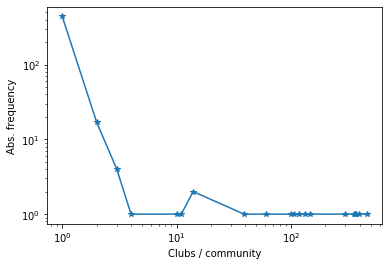

In [36]:
plt.plot(pnd_clubs_per_comm['Clubs / community'], pnd_clubs_per_comm['Count'],'*-')
plt.xlabel('Clubs / community')
plt.ylabel('Abs. frequency')

plt.xscale('log')
plt.yscale('log')

In [37]:
pnd_posit_per_comm = plot_values_per_group(i_df = player_with_comm, 
                                           value_field = 'club_position', 
                                           group_field = 'label')

pnd_posit_per_comm.columns = ['Positions / community', 'Count']

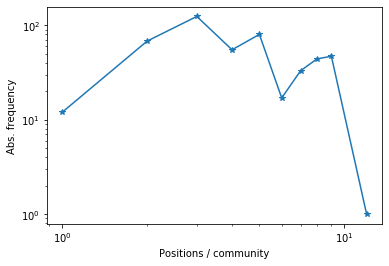

In [38]:
plt.plot(pnd_posit_per_comm['Positions / community'], pnd_posit_per_comm['Count'],'*-')
plt.xlabel('Positions / community')
plt.ylabel('Abs. frequency')

plt.xscale('log')
plt.yscale('log')

In [39]:
#erase
sys.path.insert(0, '../gremlibXL')
spark.sparkContext.addPyFile('../gremlibXL/rw_gen_spark.py')
#----- gremlibXL ----
from common_logic_rwg import *
from rw_gen_spark import *

SyntaxError: import * only allowed at module level (common_logic_rwg.py, line 32)

#### WITH PARTITIONING

In [ ]:
walk_list = [graph2walks(g) for g in l_sg]

#df_all_wlks = reduce(DataFrame.union, walk_list)

In [ ]:
walk_list[0].show(5,False)

#### WITHout PARTITIONING

In [ ]:
df_w_sample = graph2walks(sample_graph, bulk_s=20, p_node=1.0, max_len=40).persist()

In [ ]:
df_w_sample

#### Embeddings

In [ ]:
g_emb = graphEmb(input_col = 'random_walks', output_col = 'vector', npart = 1, emb_size=40)

In [ ]:
g_emb.fit(df_paths = df_w_sample)

In [ ]:
df_vect = g_emb.model.getVectors()
df_vect.count()

In [ ]:
df_players_with_vect = df_sample_data.join(df_vect, df_sample_data.name == df_vect.word, 'inner').persist()

In [ ]:
df_players_with_vect_bcn_mad = df_players_with_vect.filter(sf.col('club').isin(['Real Madrid','FC Barcelona','FC Tom Tomsk']))

pnd_players = df_players_with_vect_bcn_mad.toPandas().sort_values(by='club')



In [ ]:
plot_cos_similarities(pnd_players)

In [13]:
FORMATIONS = {'4-3-3_4': {'gk': ['cb_1', 'cb_2'],                           # Real madrid
                          'lb': ['lw', 'cb_1', 'cm_1'],
                          'cb_1': ['lb', 'cb_2', 'gk'],
                          'cb_2': ['rb', 'cb_1', 'gk'],
                          'rb': ['rw', 'cb_2', 'cm_2'],
                          'cm_1': ['cam', 'lw', 'cb_1', 'lb'],
                          'cm_2': ['cam', 'rw', 'cb_2', 'rb'],
                          'cam': ['cm_1', 'cm_2', 'st'],
                          'lw': ['cm_1', 'lb', 'st'],
                          'rw': ['cm_2', 'rb', 'st'],
                          'st': ['cam', 'lw', 'rw']},
              '5-2-2-1': {'gk': ['cb_1', 'cb_2', 'cb_3'],                   # Chelsea
                          'cb_1': ['gk', 'cb_2', 'lwb'],
                          'cb_2': ['gk', 'cb_1', 'cb_3', 'cm_1', 'cb_2'],
                          'cb_3': ['gk', 'cb_2', 'rwb'],
                          'lwb': ['cb_1', 'cm_1', 'lw'],
                          'cm_1': ['lwb', 'cb_2', 'cm_2', 'lw', 'st'],
                          'cm_2': ['rwb', 'cb_2', 'cm_1', 'rw', 'st'],
                          'rwb': ['cb_3', 'cm_2', 'rw'],
                          'lw': ['lwb', 'cm_1', 'st'],
                          'st': ['lw', 'cm_1', 'cm_2', 'rw'],
                          'rw': ['st', 'rwb', 'cm_2']},
              '4-3-3_2': {'gk': ['cb_1', 'cb_2'],                           # Man UTD / CITY
                          'lb': ['cb_1', 'cm_1'],
                          'cb_1': ['lb', 'cb_2', 'gk', 'cdm'],
                          'cb_2': ['rb', 'cb_1', 'gk', 'cdm'],
                          'rb': ['cb_2', 'cm_2'],
                          'cm_1': ['cdm', 'lw', 'lb', 'st'],
                          'cm_2': ['cdm', 'rw', 'st', 'rb'],
                          'cdm': ['cm_1', 'cm_2', 'cb_1', 'cb_2'],
                          'lw': ['cm_1', 'st'],
                          'rw': ['cm_2', 'st'],
                          'st': ['cm_1', 'cm_2', 'lw', 'rw']},              # Juventus, Bayern
              '4-2-3-1_2': {'gk': ['cb_1', 'cb_2'],
                            'lb': ['lm', 'cdm_1', 'cb_1'],
                            'cb_1': ['lb', 'cdm_1', 'gk', 'cb_2'],
                            'cb_2': ['rb', 'cdm_2', 'gk', 'cb_1'],
                            'rb': ['cb_2', 'rm', 'cdm_2'],
                            'lm': ['lb', 'cdm_1', 'st', 'cam'],
                            'rm': ['rb', 'cdm_2', 'st', 'cam'],
                            'cdm_1': ['lm', 'cb_1', 'rb', 'cam'],
                            'cdm_2': ['rm', 'cb_2', 'lb', 'cam'],
                            'cam': ['cdm_1', 'cdm_2', 'rm', 'lm', 'st'],
                            'st': ['lm', 'rm', 'cam']},
              '4-3-3': {'gk': ['cb_1', 'cb_2'],                             # Napoli
                        'lb': ['cb_1', 'cm_1'],
                        'cb_1': ['lb', 'cb_2', 'gk', 'cm_2'],
                        'cb_2': ['rb', 'cb_1', 'gk', 'cm_2'],
                        'rb': ['cb_2', 'cm_3'],
                        'cm_1': ['cm_2', 'lw', 'lb'],
                        'cm_3': ['cm_2', 'rw', 'rb'],
                        'cm_2': ['cm_1', 'cm_3', 'st', 'cb_1', 'cb_2'],
                        'lw': ['cm_1', 'st'],
                        'rw': ['cm_3', 'st'],
                        'st': ['cm_2', 'lw', 'rw']}}

In [15]:
FORMATIONS

{'4-3-3_4': {'gk': ['cb_1', 'cb_2'],
  'lb': ['lw', 'cb_1', 'cm_1'],
  'cb_1': ['lb', 'cb_2', 'gk'],
  'cb_2': ['rb', 'cb_1', 'gk'],
  'rb': ['rw', 'cb_2', 'cm_2'],
  'cm_1': ['cam', 'lw', 'cb_1', 'lb'],
  'cm_2': ['cam', 'rw', 'cb_2', 'rb'],
  'cam': ['cm_1', 'cm_2', 'st'],
  'lw': ['cm_1', 'lb', 'st'],
  'rw': ['cm_2', 'rb', 'st'],
  'st': ['cam', 'lw', 'rw']},
 '5-2-2-1': {'gk': ['cb_1', 'cb_2', 'cb_3'],
  'cb_1': ['gk', 'cb_2', 'lwb'],
  'cb_2': ['gk', 'cb_1', 'cb_3', 'cm_1', 'cb_2'],
  'cb_3': ['gk', 'cb_2', 'rwb'],
  'lwb': ['cb_1', 'cm_1', 'lw'],
  'cm_1': ['lwb', 'cb_2', 'cm_2', 'lw', 'st'],
  'cm_2': ['rwb', 'cb_2', 'cm_1', 'rw', 'st'],
  'rwb': ['cb_3', 'cm_2', 'rw'],
  'lw': ['lwb', 'cm_1', 'st'],
  'st': ['lw', 'cm_1', 'cm_2', 'rw'],
  'rw': ['st', 'rwb', 'cm_2']},
 '4-3-3_2': {'gk': ['cb_1', 'cb_2'],
  'lb': ['cb_1', 'cm_1'],
  'cb_1': ['lb', 'cb_2', 'gk', 'cdm'],
  'cb_2': ['rb', 'cb_1', 'gk', 'cdm'],
  'rb': ['cb_2', 'cm_2'],
  'cm_1': ['cdm', 'lw', 'lb', 'st'],
  'cm_2'

In [23]:
%matplotlib inline

import warnings
from text_unidecode import unidecode
from collections import deque
warnings.filterwarnings('ignore')


import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from node2vec import Node2Vec

sns.set_style('whitegrid')

ModuleNotFoundError: No module named 'node2vec'

In [ ]:
add_club_suffix = lambda x, c: x + '_{}'.format(c)

from collections import deque
import networkx as nx
graph = nx.Graph()
formatted_positions = set()

def club2graph(club_name, formation, graph):
    club_data = data[data['club'] == club_name]
    
    club_formation = FORMATIONS[formation]
    
    club_positions = dict()
    
    # Assign positions to players
    available_positions = deque(club_formation)
    available_players = set(zip(club_data['name'], club_data['club_position']))
    
    roster = dict()  # Here we will store the assigned players and positions
    
    while available_positions:
        position = available_positions.pop()
        name, pos = [(name, position) for name, p in available_players if position.startswith(p)][0]        
        
        roster[name] = pos
        
        available_players.remove((name, pos.split('_')[0]))
        
    reverse_roster = {v: k for k, v in roster.items()}
        
    # Build the graph
    for name, position in roster.items():
        # Connect to team name
        graph.add_edge(name, club_name)
        
        # Inter team connections
        for teammate_position in club_formation[position]:
            # Connect positions
            graph.add_edge(add_club_suffix(position, club_name),
                           add_club_suffix(teammate_position, club_name))
            
            # Connect player to teammate positions
            graph.add_edge(name,
                           add_club_suffix(teammate_position, club_name))
            
            # Connect player to teammates
            graph.add_edge(name, reverse_roster[teammate_position])
            
            # Save for later trimming
            formatted_positions.add(add_club_suffix(position, club_name))
            formatted_positions.add(add_club_suffix(teammate_position, club_name))
            
    return graph

In [ ]:

teams = [('real_madrid', '4-3-3_4'), 
         ('chelsea', '5-2-2-1'),
         ('manchester_utd', '4-3-3_2'),
         ('manchester_city', '4-3-3_2'),
         ('juventus', '4-2-3-1_2'),
         ('fc_bayern', '4-2-3-1_2'),
         ('napoli', '4-3-3')]

In [24]:
graph = club2graph('real_madrid', '4-3-3_4', graph)

for team, formation in teams:
    graph = club2graph(team, formation, graph)

IndexError: list index out of range